# Magnetized Plasma in FDTD using ADE with Damping

## 1. Maxwell’s Equations in a Magnetized Plasma

The **current density** $\mathbf{J}$ in a plasma evolves dynamically under electric and magnetic fields.  

**Maxwell-Ampère equation:**

$$
\nabla \times \mathbf{H} = \epsilon_0 \frac{\partial \mathbf{E}}{\partial t} + \mathbf{J}
$$

**Electron motion under Lorentz force with damping:**

$$
m_e \frac{d\mathbf{v}}{dt} + m_e \nu \mathbf{v} = -e (\mathbf{E} + \mathbf{v} \times \mathbf{B}_0)
$$

- $\nu$ is the damping (collision) rate or stabilizing factor  
- $\mathbf{B}_0$ is the static magnetic field  
- $m_e$, $e$ are electron mass and charge  

Current density:

$$
\mathbf{J} = -e n_e \mathbf{v}
$$

---

## 2. ADE for a Damped Magnetized Plasma

Introducing the **Auxiliary Differential Equation** (ADE) for $\mathbf{J}$ with damping:

$$
\frac{d\mathbf{J}}{dt} + \nu \mathbf{J} + \mathbf{\Omega} \times \mathbf{J} = \epsilon_0 \omega_p^2 \mathbf{E}
$$

where:  

- $\mathbf{\Omega} = \omega_c \hat{\mathbf{B}}_0$ (cyclotron frequency vector)  
- $\omega_p$ is the plasma frequency  
- $\nu$ is the damping rate  

This **damping term** $\nu \mathbf{J}$ helps **stabilize the FDTD update** near resonances.

Maxwell’s equations become:

$$
\begin{aligned}
\epsilon_0 \frac{\partial \mathbf{E}}{\partial t} &= \nabla \times \mathbf{H} - \mathbf{J} \\
\mu_0 \frac{\partial \mathbf{H}}{\partial t} &= -\nabla \times \mathbf{E} \\
\frac{d\mathbf{J}}{dt} + \nu \mathbf{J} + \mathbf{\Omega} \times \mathbf{J} &= \epsilon_0 \omega_p^2 \mathbf{E}
\end{aligned}
$$

---

## 3. FDTD Update Scheme with Damping

At each time step:

1. **Update magnetic field**:

$$
\mathbf{H}^{n+1/2} = \mathbf{H}^{n-1/2} - \frac{\Delta t}{\mu_0} \nabla \times \mathbf{E}^n
$$

2. **Update plasma current** (explicit Euler):

$$
\mathbf{J}^{n+1} = \mathbf{J}^{n} + \Delta t \left( \epsilon_0 \omega_p^2 \mathbf{E}^n - \nu \mathbf{J}^{n} - \mathbf{\Omega} \times \mathbf{J}^{n} \right)
$$

> Optionally, you can use **semi-implicit or trapezoidal integration** for better stability.

3. **Update electric field**:

$$
\mathbf{E}^{n+1} = \mathbf{E}^n + \frac{\Delta t}{\epsilon_0} \left( \nabla \times \mathbf{H}^{n+1/2} - \mathbf{J}^{n+1} \right)
$$

> Damping ensures **numerical stability near plasma cutoffs and cyclotron resonances**.


## Imports

In [50]:
import matplotlib.pyplot as plt
import numpy as np

import fdtd
import fdtd.backend as bd

## Set Backend

In [51]:
fdtd.set_backend("torch.cuda")

## Constants

In [52]:
WAVELENGTH = 1550e-9
SPEED_LIGHT: float = 299_792_458.0  # [m/s] speed of light
SCALE = 5
q_e = -1.6e-19
m_e = 9.e-31

## Simulation

create FDTD Grid

In [53]:
grid = fdtd.Grid(
    (2.5e-5, 1.5e-5, 1),
    grid_spacing=0.1 / (1.*SCALE) * WAVELENGTH,
    permittivity=1.0,
    permeability=1.0,
    courant_number = .1,
    plasma = True,
    use_damping = True,
)

boundaries

In [54]:
# grid[0, :, :] = fdtd.PMLBoundary(name="xbounds")
grid[0:10*SCALE, :, :] = fdtd.PML(name="pml_xlow")
grid[-10*SCALE:, :, :] = fdtd.PML(name="pml_xhigh")

# grid[:, 0, :] = fdtd.PMLBoundary(name="ybounds")
grid[:, 0:10*SCALE, :] = fdtd.PML(name="pml_ylow")
grid[:, -10*SCALE:, :] = fdtd.PML(name="pml_yhigh")

grid[:, :, 0] = fdtd.PeriodicBoundary(name="zbounds")

sources

In [55]:
grid[60*SCALE:105*SCALE, 70*SCALE:70*SCALE, 0] = fdtd.LineSource(
    period=WAVELENGTH / SPEED_LIGHT, name="linesource"
)
# grid[100, 60, 0] = fdtd.PointSource(
#     period=WAVELENGTH / SPEED_LIGHT, name="pointsource",
# )

detectors

In [56]:
grid[12e-6, :, 0] = fdtd.LineDetector(name="detector")

objects

In [57]:
for i in range(20*SCALE,60*SCALE):
    grid.omega[30*SCALE:120*SCALE,i,0:1,0:3]=.125*(1-(i-20*SCALE)/(60*SCALE-20*SCALE-1))
    # grid.OMEGA[30*SCALE:120*SCALE,i,0:1,0]=4
# grid[11*SCALE:32*SCALE, 30*SCALE:84*SCALE, 0:1] = fdtd.AnisotropicObject(permittivity=0.19, name="object")
# grid.omega[30*SCALE:120*SCALE,20*SCALE:40*SCALE,0:1,0:3]=10
print(grid.time_step)
print(.02/(bd.max(grid.OMEGA**2).item()**.5+1e-9))
print(.2/(bd.max(grid.omega).item()+1e-9))


1.0340486951142713e-17
20000000.0
1.5999999872000001


## Run simulation

In [58]:
grid.run(4000, progress_bar=True)

Courant Number  0.1
New Courant Number  0.1


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:32<00:00, 121.46it/s]


## Visualization

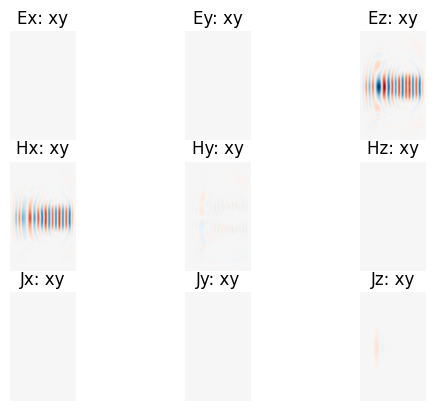

In [59]:
fig, axes = plt.subplots(3, 3, squeeze=False)
titles = ["Ex: xy", "Ey: xy", "Ez: xy", "Hx: xy", "Hy: xy", "Hz: xy", "Jx: xy", "Jy: xy", "Jz: xy"]

fields = bd.stack(
    [
        grid.E[:, :, 0, 0],
        grid.E[:, :, 0, 1],
        grid.E[:, :, 0, 2],
        grid.H[:, :, 0, 0]+0*grid.omega[:, :, 0, 0]/10,
        grid.H[:, :, 0, 1],
        grid.H[:, :, 0, 2],
        grid.J[:, :, 0, 0],
        grid.J[:, :, 0, 1],
        grid.J[:, :, 0, 2],
    ]
)

m = max(abs(fields.min().item()), abs(fields.max().item()))

for ax, field, title in zip(axes.ravel(), fields, titles):
    ax.set_axis_off()
    ax.set_title(title)
    ax.imshow(bd.numpy(field), vmin=-m, vmax=m, cmap="RdBu")

plt.show()

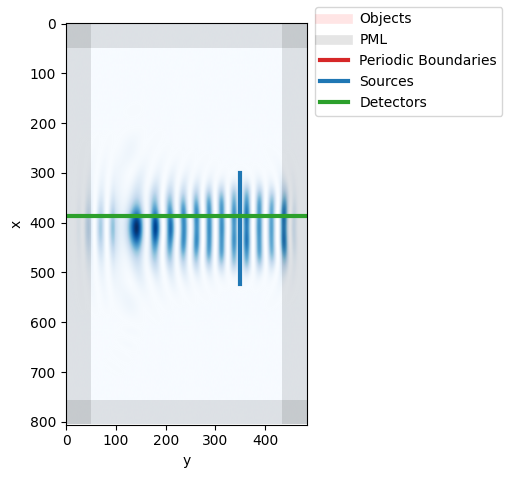

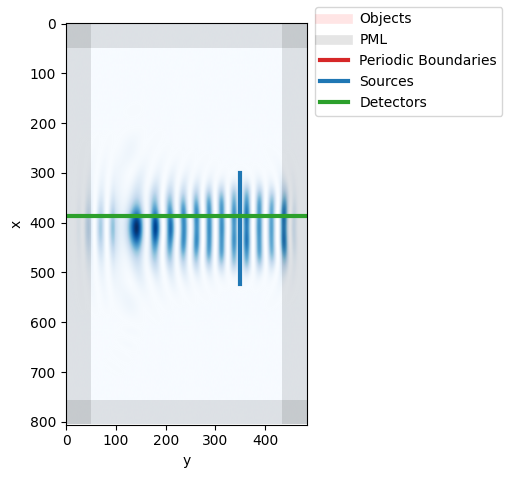

In [60]:
plt.figure()
grid.visualize(z=0)